# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split

## importando os dados

In [2]:
df = pd.read_csv('all_bovespa.csv')

In [3]:
df

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocio,volume
0,2012-01-02,ABCB4,ABC BRASIL,12.21,12.44,11.75,11.85,131800.0,1.574201e+08
1,2012-01-02,ABRE11,ABRIL EDUCA,20.57,20.85,20.57,20.85,19100.0,3.978870e+07
2,2012-01-02,AEDU3,ANHANGUERA,20.20,20.46,19.65,20.46,132100.0,2.648701e+08
3,2012-01-02,AELP3,AES ELPA,45.50,45.50,45.50,45.50,200.0,9.100000e+05
4,2012-01-02,AFLT3,AFLUENTE T,3.50,3.50,3.50,3.50,1200.0,4.200000e+05
...,...,...,...,...,...,...,...,...,...
888042,2021-08-06,YDUQ3,YDUQS PART,27.25,27.53,26.90,27.20,2829300.0,7.694204e+09
888043,2021-08-06,YUMR34,YUM BRANDS,350.01,350.01,350.01,350.01,6.0,2.100060e+05
888044,2021-08-06,Z1IO34,ZIONSBANCORP,288.91,289.40,288.60,288.60,535.0,1.545738e+07
888045,2021-08-06,Z1OM34,ZOOM VIDEO,83.09,83.09,79.97,80.22,5673.0,4.572034e+07


In [4]:
df['data_pregao'] = pd.to_datetime(df['data_pregao'], format='%Y-%m-%d')

In [5]:
#filtrar ação
df_acao = df[df['sigla_acao']=='PETR3']
df_acao

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocio,volume
218,2012-01-02,PETR3,PETROBRAS,23.13,23.61,22.74,23.21,3781500.0,8.706812e+09
550,2012-01-03,PETR3,PETROBRAS,23.21,24.02,23.21,24.02,5408100.0,1.283270e+10
884,2012-01-04,PETR3,PETROBRAS,23.80,24.28,23.57,24.17,4671600.0,1.120375e+10
1212,2012-01-05,PETR3,PETROBRAS,24.10,24.31,23.76,24.02,7909100.0,1.901147e+10
1532,2012-01-06,PETR3,PETROBRAS,24.10,24.35,23.91,24.00,3479100.0,8.355047e+09
...,...,...,...,...,...,...,...,...,...
884578,2021-08-02,PETR3,PETROBRAS,27.64,28.22,27.24,27.24,18167000.0,5.020372e+10
885416,2021-08-03,PETR3,PETROBRAS,27.30,27.70,26.66,27.70,14480700.0,3.929989e+10
886256,2021-08-04,PETR3,PETROBRAS,27.53,27.59,26.44,26.70,21499300.0,5.770513e+10
887068,2021-08-05,PETR3,PETROBRAS,29.06,29.90,28.54,29.27,56764100.0,1.662490e+11


In [6]:
#Selecionar os campos
df_acao_fec = df_acao[['data_pregao', 'preco_fechamento']]


In [7]:
#ajustar o Index
df_acao_fec = df_acao_fec.set_index(pd.DatetimeIndex(df_acao_fec['data_pregao'].values))

In [8]:
#retirar coluna
df_acao_fec.drop('data_pregao', axis = 1, inplace=True)

Text(0.5, 0, 'dara')

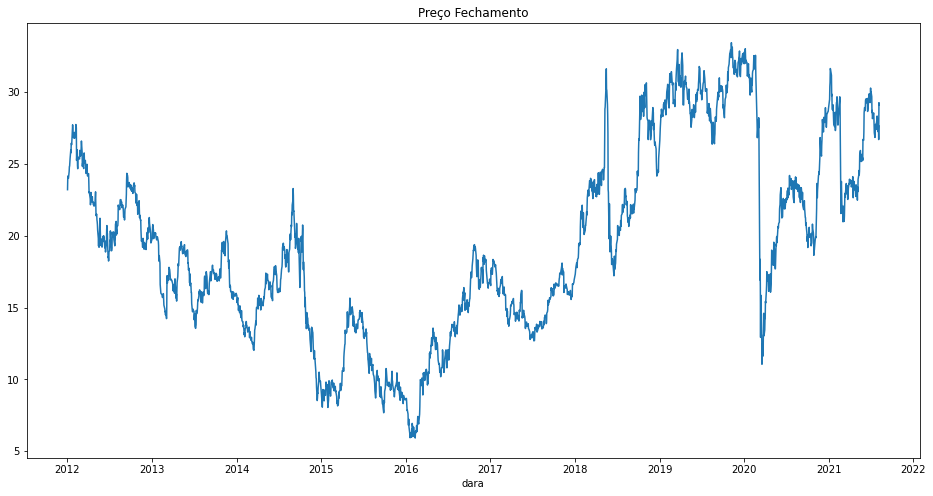

In [9]:
#plotar informação

plt.figure(figsize=(16,8))
plt.title('Preço Fechamento')
plt.plot(df_acao_fec['preco_fechamento'])
plt.xlabel('dara')

In [10]:
#verificar a quantidade de linhas
qtd_linhas = len(df_acao_fec)

qtd_linhas_treino = round(.70 * qtd_linhas)

qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

info = (
    f"linhas treino = 0:{qtd_linhas_treino}"
    f"linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste}"
    
)

info

'linhas treino = 0:1661linhas teste= 1661:2373'

In [11]:
#Normalizar os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_acao_fec)


In [12]:
#separando em treino e teste
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste]

print(len(train), len(test))

1661 712


In [13]:
#formatando os dados como a rede LSTM espera

def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in  range(len(df) - steps-1):
        a = df[ i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i + steps, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
#gerando dados de treino e teste

steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [15]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1645, 15)
(1645,)
(696, 15)
(696,)


In [16]:
#gerando os dados que o modelo espera

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
#Montando a rede

model = Sequential()

model.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

In [18]:
model.compile(optimizer ='adam', loss= 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 35)            5180      
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 35)            9940      
_________________________________________________________________
lstm_2 (LSTM)                (None, 35)                9940      
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 36        
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Treinamento do modelo

validation = model.fit(X_train, Y_train, validation_data =(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
110/110 - 7s - loss: 0.0873 - val_loss: 0.2149
Epoch 2/100
110/110 - 1s - loss: 0.0369 - val_loss: 0.1441
Epoch 3/100
110/110 - 1s - loss: 0.0340 - val_loss: 0.1095
Epoch 4/100
110/110 - 1s - loss: 0.0257 - val_loss: 0.1054
Epoch 5/100
110/110 - 1s - loss: 0.0243 - val_loss: 0.0744
Epoch 6/100
110/110 - 1s - loss: 0.0243 - val_loss: 0.1007
Epoch 7/100
110/110 - 1s - loss: 0.0241 - val_loss: 0.1534
Epoch 8/100
110/110 - 1s - loss: 0.0191 - val_loss: 0.0592
Epoch 9/100
110/110 - 1s - loss: 0.0156 - val_loss: 0.0330
Epoch 10/100
110/110 - 1s - loss: 0.0159 - val_loss: 0.0316
Epoch 11/100
110/110 - 1s - loss: 0.0162 - val_loss: 0.0765
Epoch 12/100
110/110 - 1s - loss: 0.0165 - val_loss: 0.0269
Epoch 13/100
110/110 - 1s - loss: 0.0149 - val_loss: 0.0333
Epoch 14/100
110/110 - 1s - loss: 0.0132 - val_loss: 0.0594
Epoch 15/100
110/110 - 1s - loss: 0.0143 - val_loss: 0.0229
Epoch 16/100
110/110 - 1s - loss: 0.0132 - val_loss: 0.0391
Epoch 17/100
110/110 - 1s - loss: 0.0125 - val_lo

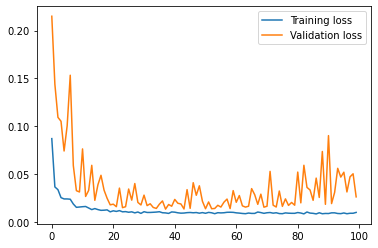

In [20]:
plt.plot(validation.history['loss'], label = 'Training loss')
plt.plot(validation.history['val_loss'], label = 'Validation loss')
plt.legend()

In [21]:
#Fazendo a previsão

prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

array([[29.943754 ],
       [28.69849  ],
       [28.16572  ],
       [28.755592 ],
       [29.684008 ],
       [29.31216  ],
       [28.285759 ],
       [28.505653 ],
       [29.19692  ],
       [28.702227 ],
       [27.871092 ],
       [28.299389 ],
       [29.424114 ],
       [28.606646 ],
       [30.168379 ],
       [30.028105 ],
       [29.668762 ],
       [30.441652 ],
       [29.534533 ],
       [28.781294 ],
       [27.512804 ],
       [27.089247 ],
       [26.755878 ],
       [25.682808 ],
       [25.769238 ],
       [26.613945 ],
       [27.208063 ],
       [27.086782 ],
       [27.191692 ],
       [26.690605 ],
       [27.058945 ],
       [28.020552 ],
       [27.801125 ],
       [28.031635 ],
       [28.277578 ],
       [29.165543 ],
       [28.562992 ],
       [28.807411 ],
       [27.317175 ],
       [27.76835  ],
       [26.114412 ],
       [25.849026 ],
       [25.782131 ],
       [25.990335 ],
       [25.98045  ],
       [25.862726 ],
       [25.14666  ],
       [24.73

In [22]:
#previsao par aos proximos 10 dias

lenght_test = len(test)
lenght_test

712

In [23]:
#pegar os ultimos dias que são o tamanho do step

days_input_steps = lenght_test - steps
days_input_steps

697

In [24]:
#transforma em array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps

array([[1.12856882, 1.19538439, 1.26219995, 1.26827409, 1.21208828,
        1.29560773, 1.27738531, 1.35483062, 1.33812673, 1.22727363,
        1.18779171, 1.25764434, 1.10579079, 1.49605442, 1.47175785]])

In [25]:
#transforamr em lista

list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[1.1285688239624057,
 1.1953843873559598,
 1.2621999507495143,
 1.2682740928762009,
 1.2120882782043483,
 1.2956077324462913,
 1.2773853060662308,
 1.3548306181814873,
 1.3381267273330988,
 1.2272736335210654,
 1.1877917096976012,
 1.257644344154499,
 1.1057907909873301,
 1.4960544226269545,
 1.4717578541202074]

In [26]:
#loop para prever os proximos 10 dias

pred_output=[]
i=0
n_future=10
while(i<n_future):
    
    if(len(list_output_steps) > steps):
        
        input_steps = np.array(list_output_steps[1:])
        print("{}dia. Valores de entrada - > {}".format(i, input_steps))
        input_steps = input_steps.reshape(1, -1)
        input_steps = input_steps.reshape((1, steps, 1))
        #print(input_steps)
        pred = model.predict(input_steps, verbose=0)
        print("{} dia. Valor previsto -> {}".format(i, pred))
        list_output_steps.extend(pred[0].tolist())
        list_output_steps=list_output_steps[1:]
        #print(list_output_steps)
        pred_output.extend(pred.tolist())
        i=i+1
    else:
        input_steps = input_steps.reshape((1, steps,1))
        pred = model.predict(input_steps, verbose=0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        i=i+1
print(pred_output)

[1.4596102]
1dia. Valores de entrada - > [1.19538439 1.26219995 1.26827409 1.21208828 1.29560773 1.27738531
 1.35483062 1.33812673 1.22727363 1.18779171 1.25764434 1.10579079
 1.49605442 1.47175785 1.45961022]
1 dia. Valor previsto -> [[1.5013859]]
2dia. Valores de entrada - > [1.26219995 1.26827409 1.21208828 1.29560773 1.27738531 1.35483062
 1.33812673 1.22727363 1.18779171 1.25764434 1.10579079 1.49605442
 1.47175785 1.45961022 1.50138593]
2 dia. Valor previsto -> [[1.5348861]]
3dia. Valores de entrada - > [1.26827409 1.21208828 1.29560773 1.27738531 1.35483062 1.33812673
 1.22727363 1.18779171 1.25764434 1.10579079 1.49605442 1.47175785
 1.45961022 1.50138593 1.53488612]
3 dia. Valor previsto -> [[1.5669374]]
4dia. Valores de entrada - > [1.21208828 1.29560773 1.27738531 1.35483062 1.33812673 1.22727363
 1.18779171 1.25764434 1.10579079 1.49605442 1.47175785 1.45961022
 1.50138593 1.53488612 1.56693745]
4 dia. Valor previsto -> [[1.5885034]]
5dia. Valores de entrada - > [1.29560773

In [27]:
#transformar a saida

prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1,-1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[29.305109514806635,
 29.525718080433556,
 29.73678541587533,
 29.878803259411146,
 29.924754087752213,
 29.83797238361801,
 29.603294546362143,
 29.199363104500577,
 28.62326560419202]

# Pegar as data de previsao


In [28]:

dates = pd.to_datetime(df_acao['data_pregao'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=9, freq='b').tolist()
predict_dates

[Timestamp('2021-08-09 00:00:00', freq='B'),
 Timestamp('2021-08-10 00:00:00', freq='B'),
 Timestamp('2021-08-11 00:00:00', freq='B'),
 Timestamp('2021-08-12 00:00:00', freq='B'),
 Timestamp('2021-08-13 00:00:00', freq='B'),
 Timestamp('2021-08-16 00:00:00', freq='B'),
 Timestamp('2021-08-17 00:00:00', freq='B'),
 Timestamp('2021-08-18 00:00:00', freq='B'),
 Timestamp('2021-08-19 00:00:00', freq='B')]

In [29]:
#criar dataframe de previsão

forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())


df_forecast = pd.DataFrame({'data_pregao': np.array(forecast_dates), 'preco_fechamento': list_output_prev})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])

df_forecast=df_forecast.set_index(pd.DatetimeIndex(df_forecast['data_pregao'].values))
df_forecast.drop('data_pregao', axis=1, inplace=True)
df_forecast

,preco_fechamento
2021-08-09,29.305110
2021-08-10,29.525718
2021-08-11,29.736785
2021-08-12,29.878803
2021-08-13,29.924754
2021-08-16,29.837972
2021-08-17,29.603295
2021-08-18,29.199363
2021-08-19,28.623266


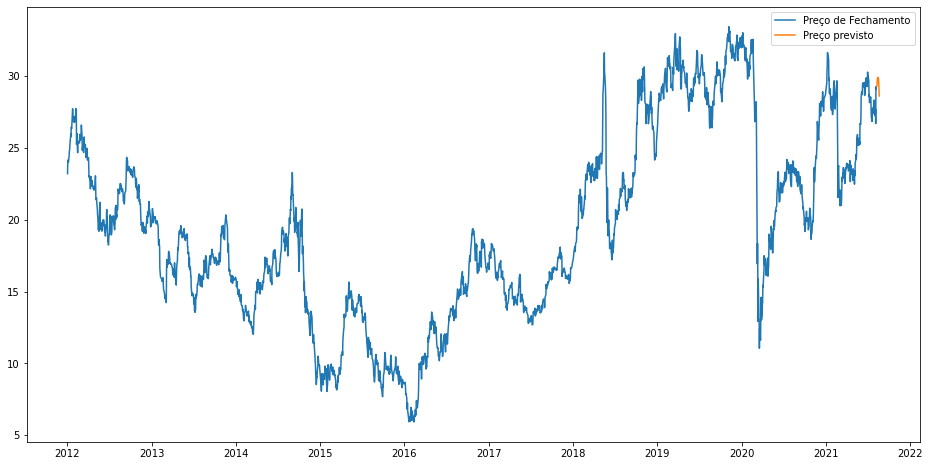

In [31]:
#plotar gráfico

plt.figure(figsize=(16,8))
plt.plot(df_acao_fec['preco_fechamento'])
plt.plot(df_forecast['preco_fechamento'])
plt.legend(['Preço de Fechamento', 'Preço previsto'])
plt.show;